# Rossman Case
### Business issue : predict the stores turnover

Authors: BOIVIN Jolyanne, BOUCHER Axel, DE BROGLIE Aymon, GRIGNARD Jeremy, KARTHIGESU Dinojan, NAULET Antoine

### Table of contents

* Introduction
* Preprocessing
* Naive Approach
* "Standard" Approach
* Statistical Approach

# Introduction

Rossmann is Germany's second drug store chain with 3600 stores in Europe. The objective of this notebook with respect to the Kaggle challenge is to predict the turnover (the sales) for each day for each store.
Predicting the turnover has huge positives impacts on companies such as :

* The possibility to optimize the supply chain and the stocking costs.
* It can give a dashboard to monitor the futur evolution of a store and make decisions about the stores.

In this notebook we will propose three approaches: a naive one, one using standard machine learning techniques not taking into account the time serie aspect and one whith added features to take into account that aspect

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
%matplotlib inline

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Grid search
from sklearn.model_selection import GridSearchCV

## Data Loading

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
store = pd.read_csv('data/store.csv')


/home/aymon/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## First Look 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [8]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
print('Here we can see that there are missing values for several features in store:', store.isnull().sum().sum())

Here we can see that there are missing values for several features in store: 2343


# Preprocessing

## Preprocessing on Train and Test

#### According to the documentation

* DateTime for Date
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


### Change the date to datetime object

In [10]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

### We first replace the '0' values present in the train and test set by 0 (int) Next we use get dummies for each present value

In [11]:
print("Train before", train['StateHoliday'].unique())
train.replace({"StateHoliday": {"0": 0}}, inplace=True)
print("Train Before", train['StateHoliday'].unique())

Train before ['0' 'a' 'b' 'c' 0]
Train Before [0 'a' 'b' 'c']


In [12]:
print("Test After", test['StateHoliday'].unique())
test.replace({"StateHoliday": {"0": 0}}, inplace=True)
print("Test After", test['StateHoliday'].unique())

Test After ['0' 'a']
Test After [0 'a']


In [13]:
train[['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']] = pd.get_dummies(train['StateHoliday'])
test[['StateHoliday_0', 'StateHoliday_a']] = pd.get_dummies(test['StateHoliday'])
train.drop('StateHoliday', axis=1, inplace=True)
test.drop('StateHoliday', axis=1, inplace=True)

### Here we check the DayOfWeek for each Nan Values of the feature Open
As we can see in the cell below, there are no Sundays when the Open value is missing. Therefore can we replace the NaN values by 1 (the store is open). To be more realistic we should map the day with a American calendar to see if each day is a sunday, special day, close day, holiday, public bank holiday, but as there are only a few missing values it should not impact the results too much

In [14]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a
479,480,622,4,2015-09-17,NaN,1,0,1,0
1335,1336,622,3,2015-09-16,NaN,1,0,1,0
2191,2192,622,2,2015-09-15,NaN,1,0,1,0
3047,3048,622,1,2015-09-14,NaN,1,0,1,0
4759,4760,622,6,2015-09-12,NaN,0,0,1,0
5615,5616,622,5,2015-09-11,NaN,0,0,1,0
6471,6472,622,4,2015-09-10,NaN,0,0,1,0
7327,7328,622,3,2015-09-09,NaN,0,0,1,0
8183,8184,622,2,2015-09-08,NaN,0,0,1,0
9039,9040,622,1,2015-09-07,NaN,0,0,1,0


In [15]:
test.replace({"Open": {np.nan: 1}}, inplace=True)

In [16]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a


Finally , we are not evaluated at dates where the store is closed so we could get rid of those dates. But it is a best practice to avoid removing and select only open days to train the model.
In case of closed days in test, it is always possible to fix the prediction at zero.

In [17]:
train = train[train['Open'] != 0 ]
#test = test[test['Open'] != 0 ]
#del train['Open']
#del test['Open']

### One hot encoding days of week

In [18]:
# this action has no effect on tree but could be usefull to avoid false relation of order in regression
train[['ld','md','mc','jd','vd','sd','dc']] = pd.get_dummies(train['DayOfWeek'])
test[['ld','md','mc','jd','vd','sd','dc']] = pd.get_dummies(test['DayOfWeek'])

## Preprocessing on Store

In [19]:
objectFeaturesStore = ['StoreType', 'Assortment', 'PromoInterval']

In [20]:
store[objectFeaturesStore].head()

,StoreType,Assortment,PromoInterval
0,c,a,NaN
1,a,a,"Jan,Apr,Jul,Oct"
2,a,a,"Jan,Apr,Jul,Oct"
3,c,c,NaN
4,a,a,NaN


According to the documentation

* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


#### Replace missing values by mean 

In [21]:
# Features to preprocess numerically
# 3 features are object type
featuresToPreprocessByMean = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear']

In [22]:
for idx in featuresToPreprocessByMean:
    store[idx] = store[idx].fillna(np.mean(store[idx]))

In [23]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### StoreType, Assortment, PromoInterval

In [24]:
print('distinct_storeType:', store['StoreType'].unique(), '\ndistinct_assortment: ', store['Assortment'].unique(), '\ndistinct_promoInterval: ', store['PromoInterval'].unique())

distinct_storeType: ['c' 'a' 'd' 'b'] 
distinct_assortment:  ['a' 'c' 'b'] 
distinct_promoInterval:  [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [25]:
store[['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']] = pd.get_dummies(store['StoreType'])
store[['Assortment_a', 'Assortment_b', 'Assortment_c']] = pd.get_dummies(store['Assortment'])
store.drop('StoreType', axis=1, inplace=True)
store.drop('Assortment', axis=1, inplace=True)

In [26]:
store.replace({"PromoInterval": {np.nan: 0}}, inplace=True)

In [27]:
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,1270.0,9.0,2008.0,0,23.595447,2011.763573,0,0,0,1,0,1,0,0
1,2,570.0,11.0,2007.0,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
2,3,14130.0,12.0,2006.0,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
3,4,620.0,9.0,2009.0,0,23.595447,2011.763573,0,0,0,1,0,0,0,1
4,5,29910.0,4.0,2015.0,0,23.595447,2011.763573,0,1,0,0,0,1,0,0


In [28]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 15 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
StoreType_a                  1115 non-null uint8
StoreType_b                  1115 non-null uint8
StoreType_c                  1115 non-null uint8
StoreType_d                  1115 non-null uint8
Assortment_a                 1115 non-null uint8
Assortment_b                 1115 non-null uint8
Assortment_c                 1115 non-null uint8
dtypes: float64(5), int64(2), object(1), uint8(7)
memory usage: 77.4+ KB


We are going to add features that encode if promo2 is active a given month

In [29]:
# This fonction tranform ununderstandable list into one shot encoding features
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
promoMonths = ['PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr', 'PromoMay', 'PromoJun', 'PromoJul', 
               'PromoAug', 'PromoSept', 'PromoOct', 'PromoNov', 'PromoDec']

for v in promoMonths:
    store[v] = 0
    
for idx, val in enumerate(store['PromoInterval']):
    if val != 0:
        mons = val.split(',')
        for mon in mons:
            columnName = 'Promo' + mon
            store.loc[idx, columnName] = 1

We are going to add two features that show the date when competition opened and one showing the date when promo2 began, those features will help for predicting as well as for building other features of interest.  

In [30]:
def date_init_compet (col1, col2):
    if col1 != 0:
        return pd.to_datetime(str('01/')+str((int(col1)))+"/"+str(int(col2)))
    
def date_init_promo(week,year):
    if week != 0: 
        return pd.to_datetime(str(int(week)) + '/' + str(int(year)) + '/' + '0', format='%W/%Y/%w')
    
store['BeginCompetition'] = store.apply(lambda x : date_init_compet(x['CompetitionOpenSinceMonth'], x['CompetitionOpenSinceYear']),axis=1) 
store['BeginPromo2'] = store.apply(lambda x : date_init_promo(x['Promo2SinceWeek'], x['Promo2SinceYear']),axis=1) 

    
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,...,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec,BeginCompetition,BeginPromo2
0,1,1270.0,9.0,2008.0,0,23.595447,2011.763573,0,0,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
1,2,570.0,11.0,2007.0,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct",1,0,...,0,0,1,0,0,1,0,0,2007-01-11,2010-04-04
2,3,14130.0,12.0,2006.0,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct",1,0,...,0,0,1,0,0,1,0,0,2006-01-12,2011-04-10
3,4,620.0,9.0,2009.0,0,23.595447,2011.763573,0,0,0,...,0,0,0,0,0,0,0,0,2009-01-09,2011-06-12
4,5,29910.0,4.0,2015.0,0,23.595447,2011.763573,0,1,0,...,0,0,0,0,0,0,0,0,2015-01-04,2011-06-12


In [31]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 29 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
StoreType_a                  1115 non-null uint8
StoreType_b                  1115 non-null uint8
StoreType_c                  1115 non-null uint8
StoreType_d                  1115 non-null uint8
Assortment_a                 1115 non-null uint8
Assortment_b                 1115 non-null uint8
Assortment_c                 1115 non-null uint8
PromoJan                     1115 non-null int64
PromoFeb                     1115 non-null int64
PromoMar                     1115 non-null int64


## Merge Train,Test and Store

In [32]:
train.columns, test.columns,store.columns, 

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
        'StateHoliday_c', 'ld', 'md', 'mc', 'jd', 'vd', 'sd', 'dc'],
       dtype='object'),
 Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'SchoolHoliday',
        'StateHoliday_0', 'StateHoliday_a', 'ld', 'md', 'mc', 'jd', 'vd', 'sd',
        'dc'],
       dtype='object'),
 Index(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
        'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
        'Assortment_c', 'PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr',
        'PromoMay', 'PromoJun', 'PromoJul', 'PromoAug', 'PromoSept', 'PromoOct',
        'PromoNov', 'PromoDec', 'BeginCompetition', 'BeginPromo2'],
       dtype='object'))

In [33]:
df_train = pd.merge(train, store, left_on='Store', right_on='Store')
df_test = pd.merge(test, store, left_on='Store', right_on='Store')

In [34]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,PromoMay,PromoJun,PromoJul,PromoAug,PromoSept,PromoOct,PromoNov,PromoDec,BeginCompetition,BeginPromo2
0,1,5,2015-07-31,5263,555,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
1,1,4,2015-07-30,5020,546,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
2,1,3,2015-07-29,4782,523,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
3,1,2,2015-07-28,5011,560,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12
4,1,1,2015-07-27,6102,612,1,1,1,1,0,...,0,0,0,0,0,0,0,0,2008-01-09,2011-06-12


In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 47 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Date                         844392 non-null datetime64[ns]
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64
Promo                        844392 non-null int64
SchoolHoliday                844392 non-null int64
StateHoliday_0               844392 non-null uint8
StateHoliday_a               844392 non-null uint8
StateHoliday_b               844392 non-null uint8
StateHoliday_c               844392 non-null uint8
ld                           844392 non-null uint8
md                           844392 non-null uint8
mc                           844392 non-null uint8
jd                           844392 non-null uint8
vd                           844392 non-null uint8
sd           

In this part, we will create  features which might be helpful to improve the model.

In [36]:
#This function returns 1 if there is a promo2 "today" 1 otherwise  
def create_promo2(promo, curr_date,begin_date, interval ):
    list_mois = ['Jan','Feb','Mar', 'Apr','May','Jun', 'Jul', 'Aug', 'Sept', 'Oct','Nov','Dec']
    if promo  and (curr_date > begin_date) and (list_mois[curr_date.month -1 ] in interval.split(',')):
        return 1 
    else:
        return 0 

In [37]:
# Creates all the features we might need to train ours models
def generator (df) :
    #Time since opoosition began
    df['duree_concurence']= (df['Date'] - pd.to_datetime(df['BeginCompetition'])).dt.days
    #1 if there is a promo2 today, 0 otherwise 
    df['promo2_today'] =df.apply( lambda x : create_promo2(x['Promo2'],x['Date'], x['BeginPromo2'] , x['PromoInterval']),axis = 1 )
    df['year']=df['Date'].apply(lambda x: x.year)
    df['month']=df['Date'].apply(lambda x: x.month)
    df['day']=df['Date'].apply(lambda x: x.day)
    df['dayofyear']=df['Date'].apply(lambda x: x.dayofyear)
    df['weekofyear']=df['Date'].apply(lambda x: x.weekofyear)
    df['dayofweek']=df['Date'].apply(lambda x: x.dayofweek)
    df['quarter']=df['Date'].apply(lambda x: x.quarter)
    
    #The length of time promo2 has been ongoing in a given store
    df['duree_promo2'] = (df['Date'] - df['BeginPromo2']).dt.days

    return (df)


We now have the datasets for training and testing with all the features we created above. The following dataframes are used as lake of features where we have all the features we thought about. We well then select some features in the following validation strategy part.

In [38]:
df_train = generator(df_train) # "Lake" of data for Training
df_test = generator(df_test) # "Lake" of data for test to submit on Kaggle

In [39]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,duree_concurence,promo2_today,year,month,day,dayofyear,weekofyear,dayofweek,quarter,duree_promo2
0,1,5,2015-07-31,5263,555,1,1,1,1,0,...,2760,0,2015,7,31,212,31,4,3,1510
1,1,4,2015-07-30,5020,546,1,1,1,1,0,...,2759,0,2015,7,30,211,31,3,3,1509
2,1,3,2015-07-29,4782,523,1,1,1,1,0,...,2758,0,2015,7,29,210,31,2,3,1508
3,1,2,2015-07-28,5011,560,1,1,1,1,0,...,2757,0,2015,7,28,209,31,1,3,1507
4,1,1,2015-07-27,6102,612,1,1,1,1,0,...,2756,0,2015,7,27,208,31,0,3,1506


In [40]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,ld,...,duree_concurence,promo2_today,year,month,day,dayofyear,weekofyear,dayofweek,quarter,duree_promo2
0,1,1,4,2015-09-17,1.0,1,0,1,0,0,...,2808,0,2015,9,17,260,38,3,3,1558
1,857,1,3,2015-09-16,1.0,1,0,1,0,0,...,2807,0,2015,9,16,259,38,2,3,1557
2,1713,1,2,2015-09-15,1.0,1,0,1,0,0,...,2806,0,2015,9,15,258,38,1,3,1556
3,2569,1,1,2015-09-14,1.0,1,0,1,0,1,...,2805,0,2015,9,14,257,38,0,3,1555
4,3425,1,7,2015-09-13,0.0,0,0,1,0,0,...,2804,0,2015,9,13,256,37,6,3,1554


## Score

We will establish a scoring metric to evaluate the quality of our model. The metric used will be the same the one used on Kaggle which is the rmspe. This allows us to compution the percentage of error we make on average 

In [41]:
def rmspe(yhat, y):  
    sum_ = 0
    for i in range(len(y)):
        if(y[i] != 0):
            sum_ += ((y[i] - yhat[i]) / y[i]) ** 2   
    rmspe = np.sqrt(sum_ / len(y))
        
    return rmspe

# adapted metric for xgboost
def rmspe_xg(yhat, y):
    return "rmspe", rmspe(yhat, y.get_label())

# Naive Approach

We try in this part what we call a naive approach. The idea behind this approach is that the board will probably ask the sales team to do as well as the previous years or better. This should make the actual sales oscillate around a certain value that we estimate by the mean.
Thus, to predict the sale for a given date, we look at what the store sold the previous years for the same date and we take the mean. 

In [42]:
class Naive:
    
    def same_day(self,day1,day2):
        """Return true if day1 and day 2 are the same day juste different year"""
        return (day1.day == day2.day) and (day1.month ==day2.month)
    
    def train(self,data,target):
        """Trains the model"""
        #Compute the mean aggregate by Days
        X = pd.concat([data['Date'].copy() , target.copy()],axis=1)
        X['Date'] =  pd.to_datetime(X['Date'])
        X['Date'] = X['Date'].apply(lambda x : (x.day,x.month))
        self.aggregate = X.groupby(['Date']).mean().reset_index()

    def predict(self,X): 
        """Predicts sales"""
        X = X.copy()
        X['Date'] =  pd.to_datetime(X['Date'])
        X['Date'] = X['Date'].apply(lambda x : (x.day,x.month))
        # Merge with the aggregate
        pred = pd.merge(pd.DataFrame(X['Date']), self.aggregate, left_on='Date', right_on='Date')
        return np.array(pred['Sales'])

In [43]:
naive_model = Naive()
naive_model.train(df_train,df_train['Sales'])

y_train_pred = naive_model.predict(df_train)

print('Error on training set ', rmspe(y_train_pred, df_train['Sales'].values))

Error on training set  0.683739371352


In [44]:
#Evaluate it on the kaggle dataset
prediction = naive_model.predict(df_test)
indic = df_test['Id']
res = pd.DataFrame(indic)
res['Sales'] = prediction
res.to_csv('data/submission_naive.csv', index = False)

The Naive approach gives a rmspe score of 0.54591 on Kaggle 

# Standard Approach

## Feature Engineering

In this part, we will create  features which might be helpful to improve the model.

In [45]:
#This function returns 1 if there is a promo2 "today" 1 otherwise  
def create_promo2(promo, curr_date,begin_date, interval ):
    list_mois = ['Jan','Feb','Mar', 'Apr','May','Jun', 'Jul', 'Aug', 'Sept', 'Oct','Nov','Dec']
    if promo  and (curr_date > begin_date) and (list_mois[curr_date.month -1 ] in interval.split(',')):
        return 1 
    else:
        return 0 

In [46]:
# Creates all the features we might need to train ours models
def generator (df) :
    #Time since opoosition began
    df['duree_concurence']= (df['Date'] - pd.to_datetime(df['BeginCompetition'])).dt.days
    #1 if there is a promo2 today, 0 otherwise 
    df['promo2_today'] =df.apply( lambda x : create_promo2(x['Promo2'],x['Date'], x['BeginPromo2'] , x['PromoInterval']),axis = 1 )
    df['year']=df['Date'].apply(lambda x: x.year)
    df['month']=df['Date'].apply(lambda x: x.month)
    df['day']=df['Date'].apply(lambda x: x.day)
    df['dayofyear']=df['Date'].apply(lambda x: x.dayofyear)
    df['weekofyear']=df['Date'].apply(lambda x: x.weekofyear)
    df['dayofweek']=df['Date'].apply(lambda x: x.dayofweek)
    df['quarter']=df['Date'].apply(lambda x: x.quarter)
    
    #The length of time promo2 has been ongoing in a given store
    df['duree_promo2'] = (df['Date'] - df['BeginPromo2']).dt.days

    return (df)


We now have the datasets for training and testing with all the features we created above. The following dataframes are used as lake of features where we have all the features we thought about. We well then select some features in the following validation strategy part.

In [47]:
df_train = generator(df_train) # "Lake" of data for Training
df_test = generator(df_test) # "Lake" of data for test to submit on Kaggle

In [48]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,duree_concurence,promo2_today,year,month,day,dayofyear,weekofyear,dayofweek,quarter,duree_promo2
0,1,5,2015-07-31,5263,555,1,1,1,1,0,...,2760,0,2015,7,31,212,31,4,3,1510
1,1,4,2015-07-30,5020,546,1,1,1,1,0,...,2759,0,2015,7,30,211,31,3,3,1509
2,1,3,2015-07-29,4782,523,1,1,1,1,0,...,2758,0,2015,7,29,210,31,2,3,1508
3,1,2,2015-07-28,5011,560,1,1,1,1,0,...,2757,0,2015,7,28,209,31,1,3,1507
4,1,1,2015-07-27,6102,612,1,1,1,1,0,...,2756,0,2015,7,27,208,31,0,3,1506


In [49]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,ld,...,duree_concurence,promo2_today,year,month,day,dayofyear,weekofyear,dayofweek,quarter,duree_promo2
0,1,1,4,2015-09-17,1.0,1,0,1,0,0,...,2808,0,2015,9,17,260,38,3,3,1558
1,857,1,3,2015-09-16,1.0,1,0,1,0,0,...,2807,0,2015,9,16,259,38,2,3,1557
2,1713,1,2,2015-09-15,1.0,1,0,1,0,0,...,2806,0,2015,9,15,258,38,1,3,1556
3,2569,1,1,2015-09-14,1.0,1,0,1,0,1,...,2805,0,2015,9,14,257,38,0,3,1555
4,3425,1,7,2015-09-13,0.0,0,0,1,0,0,...,2804,0,2015,9,13,256,37,6,3,1554


In [50]:
# this step ends the approach without statistics. We save the result in order to make comparison of methods further.
df_train.to_csv("data/df_1.csv", index=False)
df_test.to_csv("data/df_1_test.csv",index=False)

## Validation strategy

In this part we will first split the train set to have a validation and train set.
Then we will choose the features we want to keep to train our model, from the lake of features we created in the previous part.
We will apply our selection to training, validation and test sets.

In [52]:
# going back to the general approach
df_train = pd.read_csv('data/df_1.csv')
df_test = pd.read_csv('data/df_1_test.csv')

### Split into train and validation set

In [53]:
train, validation = train_test_split(df_train, test_size=0.1)

In [55]:
train.shape, validation.shape

((759952, 57), (84440, 57))

### Feature Selection

In [56]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'ld', 'md', 'mc', 'jd', 'vd', 'sd', 'dc',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr',
       'PromoMay', 'PromoJun', 'PromoJul', 'PromoAug', 'PromoSept', 'PromoOct',
       'PromoNov', 'PromoDec', 'BeginCompetition', 'BeginPromo2',
       'duree_concurence', 'promo2_today', 'year', 'month', 'day', 'dayofyear',
       'weekofyear', 'dayofweek', 'quarter', 'duree_promo2'],
      dtype='object')

In [57]:
featuresToTakeForTraining = ['Store', 'DayOfWeek', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'duree_concurence', 'promo2_today', 'year', 'month', 'day', 'dayofyear',
       'weekofyear', 'dayofweek', 'quarter', 'duree_promo2']

In [58]:
y_train = train['Sales']
y_validation = validation['Sales']

X_train = train[featuresToTakeForTraining]
X_validation = validation[featuresToTakeForTraining]
X_test = df_test[featuresToTakeForTraining]


In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759952 entries, 628773 to 476468
Data columns (total 27 columns):
Store                        759952 non-null int64
DayOfWeek                    759952 non-null int64
Promo                        759952 non-null int64
SchoolHoliday                759952 non-null int64
CompetitionDistance          759952 non-null float64
CompetitionOpenSinceMonth    759952 non-null float64
CompetitionOpenSinceYear     759952 non-null float64
Promo2                       759952 non-null int64
Promo2SinceWeek              759952 non-null float64
Promo2SinceYear              759952 non-null float64
StoreType_a                  759952 non-null int64
StoreType_b                  759952 non-null int64
StoreType_c                  759952 non-null int64
StoreType_d                  759952 non-null int64
Assortment_a                 759952 non-null int64
Assortment_b                 759952 non-null int64
Assortment_c                 759952 non-null int64
duree_c

In [60]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 27 columns):
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Promo                        41088 non-null int64
SchoolHoliday                41088 non-null int64
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
StoreType_a                  41088 non-null int64
StoreType_b                  41088 non-null int64
StoreType_c                  41088 non-null int64
StoreType_d                  41088 non-null int64
Assortment_a                 41088 non-null int64
Assortment_b                 41088 non-null int64
Assortment_c                 41088 non-null int64
duree_concurence             41

## Training Pipeline

In [61]:
# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Grid search
from sklearn.model_selection import GridSearchCV

### XGboost implementation that we train separatly

In [62]:
def get_prob(y):
    y[y < 0] = 0
    return y

In [63]:
params = {"objective": "reg:linear", # loss => linear regression because we predict sales
          "eta": 0.3,
          "max_depth": 8, #we can increase the depth but we might overfit
          "subsample": 0.7,
          "colsample_bytree": 0.7
          }

dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))

dvalid = xgb.DMatrix(X_validation, np.log(y_validation + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

model = xgb.train(params, dtrain, 200, evals = watchlist, early_stopping_rounds = 30, feval = rmspe_xg, verbose_eval = 5)

[0]	eval-rmse:5.79337	train-rmse:5.79395	eval-rmspe:0.659589	train-rmspe:0.659621
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 30 rounds.
[5]	eval-rmse:1.02281	train-rmse:1.02374	eval-rmspe:0.114077	train-rmspe:0.114199
[10]	eval-rmse:0.336496	train-rmse:0.33664	eval-rmspe:0.036696	train-rmspe:0.036844
[15]	eval-rmse:0.266414	train-rmse:0.265755	eval-rmspe:0.029509	train-rmspe:0.029646
[20]	eval-rmse:0.251309	train-rmse:0.25007	eval-rmspe:0.027881	train-rmspe:0.028002
[25]	eval-rmse:0.235239	train-rmse:0.233515	eval-rmspe:0.025977	train-rmspe:0.026074
[30]	eval-rmse:0.218967	train-rmse:0.216314	eval-rmspe:0.023999	train-rmspe:0.024078
[35]	eval-rmse:0.206234	train-rmse:0.202865	eval-rmspe:0.022438	train-rmspe:0.022495
[40]	eval-rmse:0.194966	train-rmse:0.190823	eval-rmspe:0.021064	train-rmspe:0.021091
[45]	eval-rmse:0.186956	train-rmse:0.181823	eval-rmspe:0.020071	train-rmspe:0.020076
[50]	eval-r

In [64]:
train_probs = model.predict(xgb.DMatrix(X_train))
validation_probs = model.predict(xgb.DMatrix(X_validation))

print('Error on training set ', rmspe(np.exp(get_prob(train_probs))-1, y_train.values))
print('Error on validation set ', rmspe(np.exp(get_prob(validation_probs))-1, y_validation.values))

Error on training set  0.145690379186
Error on validation set  0.135993724837


### If we try to select some features in order to decrease the RMSPE

In [65]:
featuresToTakeForTraining = ['Store', 'DayOfWeek', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c','year', 'month', 'day']

y_train = train['Sales']
y_validation = validation['Sales']

X_train = train[featuresToTakeForTraining]
X_validation = validation[featuresToTakeForTraining]
X_test = df_test[featuresToTakeForTraining]

In [66]:
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))

dvalid = xgb.DMatrix(X_validation, np.log(y_validation + 1))
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

model = xgb.train(params, dtrain, 300, evals = watchlist, early_stopping_rounds = 30, feval = rmspe_xg, verbose_eval = 10)

[0]	eval-rmse:5.7931	train-rmse:5.79372	eval-rmspe:0.65961	train-rmspe:0.659653
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 30 rounds.
[10]	eval-rmse:0.340368	train-rmse:0.341237	eval-rmspe:0.03717	train-rmspe:0.037382
[20]	eval-rmse:0.24653	train-rmse:0.246058	eval-rmspe:0.027337	train-rmspe:0.027493
[30]	eval-rmse:0.214948	train-rmse:0.213184	eval-rmspe:0.023538	train-rmspe:0.023592
[40]	eval-rmse:0.189728	train-rmse:0.186918	eval-rmspe:0.020423	train-rmspe:0.020412
[50]	eval-rmse:0.175161	train-rmse:0.171518	eval-rmspe:0.018595	train-rmspe:0.018557
[60]	eval-rmse:0.163412	train-rmse:0.158754	eval-rmspe:0.017078	train-rmspe:0.016994
[70]	eval-rmse:0.15697	train-rmse:0.151781	eval-rmspe:0.016233	train-rmspe:0.016118
[80]	eval-rmse:0.152043	train-rmse:0.146119	eval-rmspe:0.015576	train-rmspe:0.015436
[90]	eval-rmse:0.147954	train-rmse:0.141554	eval-rmspe:0.015033	train-rmspe:0.014875
[100]	eval-

In [67]:
train_probs = model.predict(xgb.DMatrix(X_train))
validation_probs = model.predict(xgb.DMatrix(X_validation))

print('Error on training set ', rmspe(np.exp(get_prob(train_probs))-1, y_train.values))
print('Error on validation set ', rmspe(np.exp(get_prob(validation_probs))-1, y_validation.values))

Error on training set  0.12560968908
Error on validation set  0.1322900933


### Different Sklearn Regressors implementations

##### Definition of the algorithm and theirs parameters for the grid search

In [68]:
names_regressors = ["DecisionTreeRegressor", "RandomForestRegressor", "ExtraTreesRegressor", "XGBoost"]

regressors = [
    DecisionTreeRegressor(max_depth=None, min_samples_split=2, random_state=0),
    RandomForestRegressor(n_estimators = 10, max_depth = None, min_samples_split = 2, random_state = 0),
    ExtraTreesRegressor(n_estimators = 10, max_depth = None, min_samples_split = 2, random_state = 0),
    model
    ]

##### Training of the different algoritms

In [69]:
scores = []
scores_train = []

# iterate over classifiers
for clf, name in zip(regressors, names_regressors):
    print (name)
    if(name != "XGBoost"):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_validation)
        y_pred_train = clf.predict(X_train)
        score_train = rmspe(y_pred_train, y_train.values)
        score = rmspe(y_pred, y_validation.values)
        print("\t Score (trainning):", score_train, "\n")
        print("\t Score (testing):", score, "\n")
    else:
        train_probs = clf.predict(xgb.DMatrix(X_train))
        test_probs = clf.predict(xgb.DMatrix(X_validation))
        score_train = rmspe(np.exp(get_prob(train_probs)) - 1, y_train.values)
        score = rmspe(np.exp(get_prob(test_probs)) - 1, y_validation.values)
        print("\t Score (trainning):", score_train, "\n")
        print("\t Score (testing):", score, "\n")
    scores.append(score)
    scores_train.append(score_train)


DecisionTreeRegressor
	 Score (trainning): 0.0 

	 Score (testing): 0.204170585825 

RandomForestRegressor
	 Score (trainning): 0.0698377870293 

	 Score (testing): 0.168673378278 

ExtraTreesRegressor
	 Score (trainning): 6.3179138783e-05 

	 Score (testing): 0.163772132529 

XGBoost
	 Score (trainning): 0.12560968908 

	 Score (testing): 0.1322900933 



##### Plot the different scores

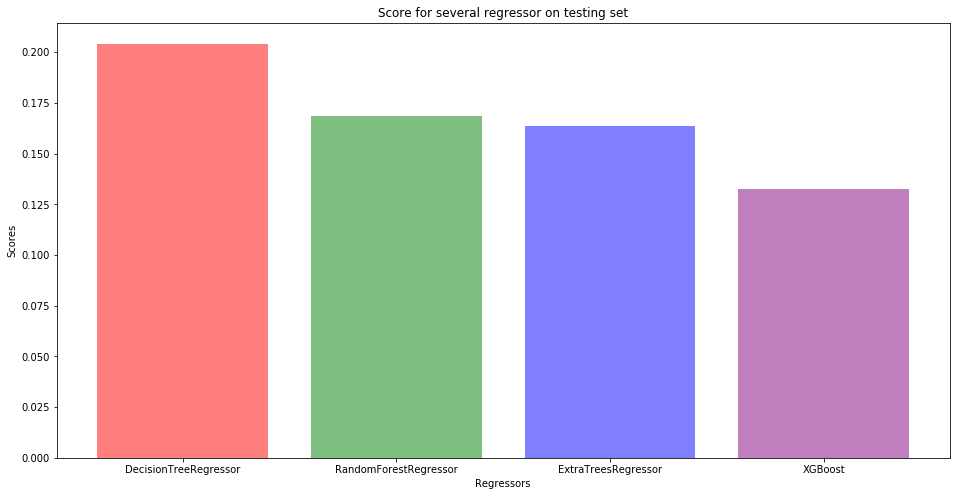

In [70]:
plt.figure(figsize=(16, 8))
x = np.arange(len(scores))
plt.bar(x, scores, alpha=0.5, color=["red", "green", "blue", "purple"])
plt.xticks(x, names_regressors)
plt.xlabel("Regressors")
plt.ylabel("Scores")
plt.title("Score for several regressor on testing set")
plt.show()

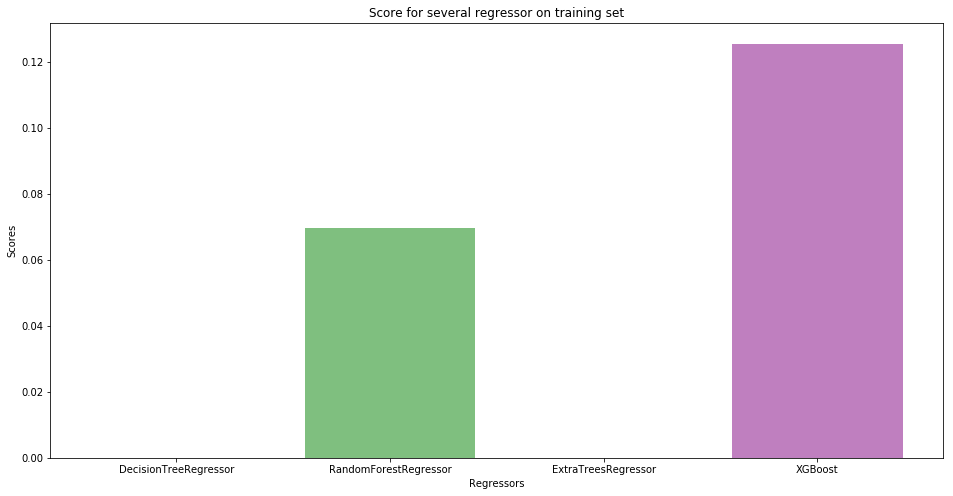

In [71]:
plt.figure(figsize=(16, 8))
x = np.arange(len(scores))
plt.bar(x, scores_train, alpha=0.5, color=["red", "green", "blue", "purple"])
plt.xticks(x, names_regressors)
plt.xlabel("Regressors")
plt.ylabel("Scores")
plt.title("Score for several regressor on training set")
plt.show()

XGBoost is the best model

## Evaluation and Comparison

Show the best features of the xgboost model 

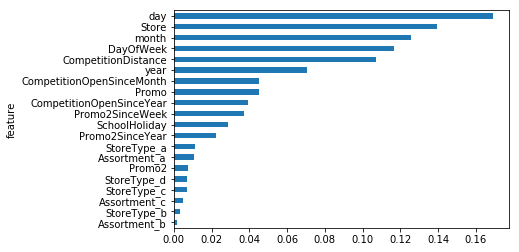

In [72]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
#Store in dataframe for plotting 
importance = pd.DataFrame(importance,columns = ['feature','score'])
#Make the score relative 
importance['score'] = importance['score']/importance['score'].sum()
importance.plot(kind ='barh' , x = 'feature' , y = 'score',legend = False)

This approach yields a score of 0.19 on Kaggle which is significantly better than the naive approach, moreover we can get insights on the prediction as we know which features are the most important 

# Statistical Approach

## From statistics to features
### first step: creation of dataframe of statistics

In this part, we add "statisctical" features, that is features computed from temporal statistics, this allows use to describe the "time serie" effect 

In [81]:
# this generator is made specificly for thos dataset but should be easily generalized. It creates some
# statistics mesasurement on the past
def statMaker (dfs, group):
    df_stat=[]
    df_stat=pd.DataFrame(df_stat)   
    for week in range(52):
        week=week+1
        nom = 'mean_w_' + str(week)
        df_stat[nom]=df_s[(df_s['weekofyear']==week)].groupby('Store')[group].mean()
    df_stat=df_stat.reset_index()

    df_w=[]
    df_w=pd.DataFrame(df_w)
    for week in range(52):
        week=week+1
        for dow in range(7):
            dow=dow+1
            nom = 'w'+str(week)+'_d'+str(dow)
            df_w[nom]=df_s[(df_s['weekofyear']==week) & (df_s['dayofweek']==dow)].groupby('Store')[group].mean()
    df_w=df_w.reset_index()

    df_m=[]
    df_m=pd.DataFrame(df_m)
    for month in range(12):
        month=month+1
        nom = 'm'+str(month)
        df_m[nom]=df_s[(df_s['month']==month)].groupby('Store')[group].mean()
    df_m=df_m.reset_index()

    df_dm=[]
    df_dm=pd.DataFrame(df_dm)    
    for month in range(12):
        month=month+1
        nom = 'dif_m'+str(month)
        df_dm[nom]=df_s[(df_s['month']==month) & (df_s['year']==2014)].groupby('Store')[group].mean() - df_s[(df_s['month']==month) & (df_s['year']==2013)].groupby('Store')[group].mean()
    df_dm=df_dm.reset_index()

    df_dq=[]
    df_dq=pd.DataFrame(df_dq)
    for quarter in range(4):
        quarter+=1
        nom = 'dif_q'+str(quarter)
        df_dq[nom]=df_s[(df_s['quarter']==quarter) & (df_s['year']==2014)].groupby('Store')[group].mean() - df_s[(df_s['quarter']==quarter) & (df_s['year']==2013)].groupby('Store')[group].mean()
    df_dq=df_dq.reset_index()

    df_stat = pd.merge(df_stat, df_w, left_on='Store', right_on='Store')
    df_stat = pd.merge(df_stat, df_m, left_on='Store', right_on='Store')
    df_stat = pd.merge(df_stat, df_dm, left_on='Store', right_on='Store')
    df_stat = pd.merge(df_stat, df_dq, left_on='Store', right_on='Store')
    return (df_stat)
# now we create the dataframe of stats for customers and sales
df_s = df_train.copy()
df_stat_sales = statMaker (df_train, 'Sales')
df_stat_cust = statMaker (df_train, 'Customers')
df_stat_sales=df_stat_sales.fillna(0)
df_stat_cust=df_stat_cust.fillna(0)
df_stat_sales.to_csv("data/stat_sales.csv", index=False)
df_stat_cust.to_csv("data/stat_cust.csv", index=False)


### second step: affectation of statistics as features

In [74]:
# this part is one example of exploitation of the statistics

def affect_meanW (col_store, col_woy, df_stat):
    col_store = int(col_store)
    nom='mean_w_' + str(col_woy)
    res = df_stat[df_stat['Store']==col_store][nom]
    return int(res)

def affect_meanD (col_store,col_woy, col_dow, df_stat):
    col_store = int(col_store)
    col_dow+=1
    nom = 'w'+str(col_woy)+'_d'+str(col_dow)
    res = df_stat[df_stat['Store']==col_store][nom]
    return int(res)

def affect_meanM (col_store, col_month, df_stat):
    col_store = int(col_store)
    nom= 'm'+str(col_month)
    res = df_stat[df_stat['Store']==col_store][nom]
    return int(res)

def affect_difM (col_store, col_month, df_stat):
    col_store = int(col_store)
    nom = 'dif_m'+str(col_month)
    res = df_stat[df_stat['Store']==col_store][nom]
    return int(res)

def affect_difQ (col_store, col_quarter, df_stat):
    col_store = int(col_store)
    nom = 'dif_q'+str(col_quarter)
    res = df_stat[df_stat['Store']==col_store][nom]
    return int(res)

def generator_stat (df, df_stat, name) :
    df[name+'_mean_w']=df.apply( lambda x : affect_meanW(x['Store'],x['weekofyear'], df_stat),axis = 1 )
    df[name+'_mean_d']=df.apply( lambda x : affect_meanD(x['Store'],x['weekofyear'], x['dayofweek'], df_stat),axis = 1 )
    df[name+'_mean_m']=df.apply( lambda x : affect_meanM(x['Store'],x['month'], df_stat),axis = 1)
    df[name+'_dif_m']=df.apply( lambda x : affect_difM(x['Store'],x['month'], df_stat),axis = 1)
    df[name+'_dif_q']=df.apply( lambda x : affect_difQ(x['Store'],x['quarter'], df_stat),axis = 1)
    return (df)

In [75]:
# choice is made to use only the samples on the same context than the test
df_train=df_train[((df_train['year']>2013) & (df_train['month']>6) & (df_train['month']<10))|((df_train['year']>2014) & (df_train['month']>4)) ]

df_train= generator_stat(df_train, df_stat_sales,'sales')
df_train= generator_stat(df_train, df_stat_cust,'cust')
df_test = generator_stat(df_test, df_stat_sales,'sales')
df_test = generator_stat(df_test, df_stat_cust,'cust')

#some additional features are extracted from the ratio sales and customers
df_train['ratio_m']= df_train['sales_mean_m']/(df_train['cust_mean_m']+0.1)
df_train['ratio_w']= df_train['sales_mean_w']/(df_train['cust_mean_w']+0.1)
df_train['ratio_d']= df_train['sales_mean_d']/(df_train['cust_mean_d']+0.1)
df_test['ratio_m']= df_test['sales_mean_m']/(df_test['cust_mean_m']+0.1)
df_test['ratio_w']= df_test['sales_mean_w']/(df_test['cust_mean_w']+0.1)
df_test['ratio_d']= df_test['sales_mean_d']/(df_test['cust_mean_d']+0.1)

#pour expoiter les dates, le choix est fait de les convertir en ordinal
list_date = [ 'Date', 'BeginCompetition', 'BeginPromo2',]
for col in list_date :
    df_train[col] = pd.to_datetime(df_train[col])
    df_train[col] =df_train[col].apply(lambda x: x.toordinal())
    df_test[col] = pd.to_datetime(df_test[col])
    df_test[col] =df_test[col].apply(lambda x: x.toordinal())

In [76]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'ld', 'md', 'mc', 'jd', 'vd', 'sd', 'dc',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'PromoJan', 'PromoFeb', 'PromoMar', 'PromoApr',
       'PromoMay', 'PromoJun', 'PromoJul', 'PromoAug', 'PromoSept', 'PromoOct',
       'PromoNov', 'PromoDec', 'BeginCompetition', 'BeginPromo2',
       'duree_concurence', 'promo2_today', 'year', 'month', 'day', 'dayofyear',
       'weekofyear', 'dayofweek', 'quarter', 'duree_promo2', 'sales_mean_w',
       'sales_mean_d', 'sales_mean_m', 'sales_dif_m', 'sales_dif_q',
       'cust_mean_w', 'cust_mean_d', 'cust_mean_m', 'cust_dif_m', 'cust

## Normalization of the features
This approach is not relevant regarding results when it is systematicaly applied
but should be revisited in close cooperation with domain experts

In [77]:
featuresToNorm = ['CompetitionDistance', 
       'duree_concurence', 'month', 'weekofyear', 'dayofweek',
        'duree_promo2', 'sales_mean_w',
       'sales_mean_d', 'sales_mean_m', 'sales_dif_m', 'sales_dif_q',
       'cust_mean_w', 'cust_mean_d', 'cust_mean_m', 'cust_dif_m', 'cust_dif_q',
       'ratio_m', 'ratio_w', 'ratio_d']
featuresToNormTest = ['CompetitionDistance', 
       'duree_concurence', 'month', 'weekofyear', 'dayofweek',
        'duree_promo2', 'sales_mean_w',
       'sales_mean_d', 'sales_mean_m', 'sales_dif_m', 'sales_dif_q',
       'cust_mean_w', 'cust_mean_d', 'cust_mean_m', 'cust_dif_m', 'cust_dif_q',
       'ratio_m', 'ratio_w', 'ratio_d']

def normalize(df):
    list_col = df.columns.values.tolist()
    for col in list_col :
        df[col]= (df[col])/(df[col].max())
    return df

def normalize_hard(df):
    list_col = df.columns.values.tolist()
    for col in list_col :
        df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min())
    return df

#df_train [featuresToNorm] = normalize (df_train[featuresToNorm])

#df_test [featuresToNormTest]= normalize(df_test[featuresToNormTest]) 

In [78]:
# this step ends the stastistical preprocessing
df_train.to_csv("data/dfStat.csv", index=False)
df_test.to_csv("data/dfStat_test.csv",index=False)

## Regressors with grid search based on time series
In this part we come back to the statistical approach in order to provide comparison. This why we use the same algorithms. We don't include this approach into the general one because its generalization should need more effort in industrialization part. This is only a prototype.

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#laoding saved datas preprocessed with stats
df_train = pd.read_csv('data/dfStat.csv')
#sorting of value by dates to use TimeSeriesSplit
df_train = df_train.sort_values(by = 'Date')
df_test = pd.read_csv('data/dfStat_test.csv')
#possibility to restrain the training set on more relevant windows
df_train=df_train[((df_train['year']>2013) & (df_train['month']>7) & (df_train['month']<10))|((df_train['year']>2014) & (df_train['month']>6)) ]
#selection of most relevant samples for fitting
df_train=df_train[df_train['Open']==1]
df_train=df_train[df_train['StateHoliday_0']==1]
#spliting for training and validation
train, validation = train_test_split(df_train, test_size=0.1)
#features selection: large choice is possible because of the high number of samples
featuresToTakeForTraining = ['vd', 'StoreType_d', 'PromoMay', 'duree_concurence', 'sales_mean_w', 'ratio_m',
 'StoreType_a', 'PromoOct', 'cust_mean_d', 'jd', 'PromoApr', 'duree_promo2', 'CompetitionDistance', 'sales_dif_m',
 'SchoolHoliday', 'ld', 'PromoJan', 'day', 'PromoFeb', 'StoreType_c', 'PromoAug', 'Promo2', 'sales_dif_q',
 'PromoDec', 'PromoSept', 'Assortment_c', 'Date']
X_train = train[featuresToTakeForTraining]
X_validation = validation[featuresToTakeForTraining]
X_test = df_test[featuresToTakeForTraining]
y_train = train['Sales']
y_validation = validation['Sales']

#first model: XGB
model = xgb.XGBRegressor()
#param for grid search, more params have been tested during the prototyping phase
param_search = {"max_depth": [11,13]}
#choice of time serie spliting
my_cv = TimeSeriesSplit(n_splits=4).split(X_train)
#grid search
gsearch = GridSearchCV(estimator=model, cv=my_cv, param_grid=param_search)
#fitting
gsearch.fit(X_train, y_train)
#prediction and results
y_pred_t = gsearch.predict(X_train)
y_pred_v = gsearch.predict(X_validation)
print('\t score train', rmspe(get_prob(y_pred_t), y_train.values))
print('\t score validation', rmspe(get_prob(y_pred_v), y_validation.values))
print('XGB', " Best parameters :", gsearch.best_params_, "RMSPE", "\n")

#other regressors, more famous and interpretable
names_regressors_tunedParams = [
    ["ExtraTreesRegressor", ExtraTreesRegressor(), {"max_depth" :[None], "min_samples_split": [4,6] } ],
    ["DecisionTreeRegressor", DecisionTreeRegressor(), {"max_depth" :[12,14], "min_samples_split": [8,10] }],
    ["RandomForestRegressor", RandomForestRegressor(n_estimators=50), {"max_depth": [10,12,14], "bootstrap": [True]}]]

for name, regressor, tunedParam in names_regressors_tunedParams:
    my_cv = TimeSeriesSplit(n_splits=4).split(X_train)
    clf = GridSearchCV(estimator=regressor, cv=my_cv, param_grid=tunedParam)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_validation)    
    y_pred_t = clf.predict(X_train)
    y_pred_v = clf.predict(X_validation)
    print('\t score train', rmspe(y_pred_t, y_train.values))
    print('\t score validation', rmspe(y_pred_v, y_validation.values))
    print(name, "Best parameters :", clf.best_params_, "RMSPE", "\n")

	 score train 0.0746954832393
	 score validation 0.120805162542
XGB  Best parameters : {'max_depth': 11} RMSPE 

	 score train 0.0451822432171
	 score validation 0.135278344345
ExtraTreesRegressor Best parameters : {'max_depth': None, 'min_samples_split': 6} RMSPE 

	 score train 0.134049283811
	 score validation 0.158852926083
DecisionTreeRegressor Best parameters : {'max_depth': 12, 'min_samples_split': 10} RMSPE 

	 score train 0.0967981880782
	 score validation 0.13788730384
RandomForestRegressor Best parameters : {'bootstrap': True, 'max_depth': 14} RMSPE 



## features selection - auto
Approach consisting in deleting of non usefull features. In this book we have already reinsert the result into the previous step.

In [80]:
def remove_if_exists(L, l_val):
    for value in l_val:
        try:
            L.remove(value)
        except ValueError:
            pass
    return L

features_selected = featuresToTakeForTraining
best_res=1
model = xgb.XGBRegressor()
y_sel = df_train['Sales']
X_sel = df_train[features_selected]
model.fit(X_sel, y_sel)
y_pred_v = model.predict(X_validation[features_selected])
best_res = rmspe(get_prob(y_pred_v), y_validation.values)
print('baseline :', best_res, '\n')

for f in featuresToTakeForTraining :
    features_selected = remove_if_exists(features_selected,[f])
    X_sel = df_train[features_selected]
    model.fit(X_sel, y_sel)
    y_pred_v = model.predict(X_validation[features_selected])
    res = rmspe(get_prob(y_pred_v), y_validation.values)
    del(X_sel)
    if res < best_res:
        print('feature non retenue :', f,res, '\n')
        best_res = res
    else:
        features_selected.append(f)
        print('feature retenue :', f,res, '\n')

baseline : 0.19116019475 

feature retenue : vd 0.194015727013 

feature retenue : PromoMay 0.19116019475 

feature retenue : sales_mean_w 0.297801206518 

feature retenue : StoreType_a 0.194524451949 

feature retenue : cust_mean_d 0.216671513753 

feature retenue : PromoApr 0.19116019475 

feature retenue : CompetitionDistance 0.192808568699 

feature retenue : SchoolHoliday 0.192711791733 

feature retenue : PromoJan 0.19116019475 

feature retenue : PromoFeb 0.19116019475 

feature retenue : PromoAug 0.19116019475 

feature retenue : sales_dif_q 0.192855944713 

feature retenue : PromoSept 0.19116019475 

feature retenue : Date 0.203443533978 

feature retenue : PromoMay 0.19116019475 

feature retenue : StoreType_a 0.194524451949 

feature retenue : PromoApr 0.19116019475 

feature retenue : SchoolHoliday 0.192711791733 

feature retenue : PromoFeb 0.19116019475 

feature retenue : sales_dif_q 0.192855944713 

feature retenue : Date 0.203443533978 

feature retenue : StoreType_a 0

## Evaluation

The best Kaggle score with this approach is 0.147. The validation score which is the most important in case of strategic simulation of new deployments is under 0.10 which is very confident area.

# Conclusion

In conclusion, we tested 3 approaches: a Naive one with a score of 0.54, a standard one with a score of 0.19 and a statictical one with a score of 0.147. 
There is real added value to the use of ML for this problem as the performance is improved significantly, moreover both approach can be introspected to look at the most relevant features in order to optimize sales 